<a href="https://colab.research.google.com/github/VincentGranville/Notebooks/blob/main/GAN_Telecom_test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding
from keras.layers import LeakyReLU
from keras.layers import concatenate
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
import scipy.stats
import datetime as dt
import pydot
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
url = 'https://raw.githubusercontent.com/shakti2594/Shared_dataset/main/Telco-Customer-Churn.csv'
df = pd.read_csv(url)
print(df.shape)
df.head(2)

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


In [ ]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [ ]:
print(df.isna().sum().sum())
df = df.dropna()
df.shape
print(df.isna().sum().sum())

11
0


In [ ]:
def convert_categorical_columns_to_str(df):
    for col in df.select_dtypes(include='object'):
        df[col] = df[col].astype('string')
    return df
df = convert_categorical_columns_to_str(df)

In [ ]:
df.dtypes

customerID           string
gender               string
SeniorCitizen         int64
Partner              string
Dependents           string
tenure                int64
PhoneService         string
MultipleLines        string
InternetService      string
OnlineSecurity       string
OnlineBackup         string
DeviceProtection     string
TechSupport          string
StreamingTV          string
StreamingMovies      string
Contract             string
PaperlessBilling     string
PaymentMethod        string
MonthlyCharges      float64
TotalCharges        float64
Churn                string
dtype: object

#### **Checking Skew/Normalization**

In [ ]:
skew = df[['MonthlyCharges', 'TotalCharges']].skew()
print(skew)

MonthlyCharges   -0.222103
TotalCharges      0.961642
dtype: float64


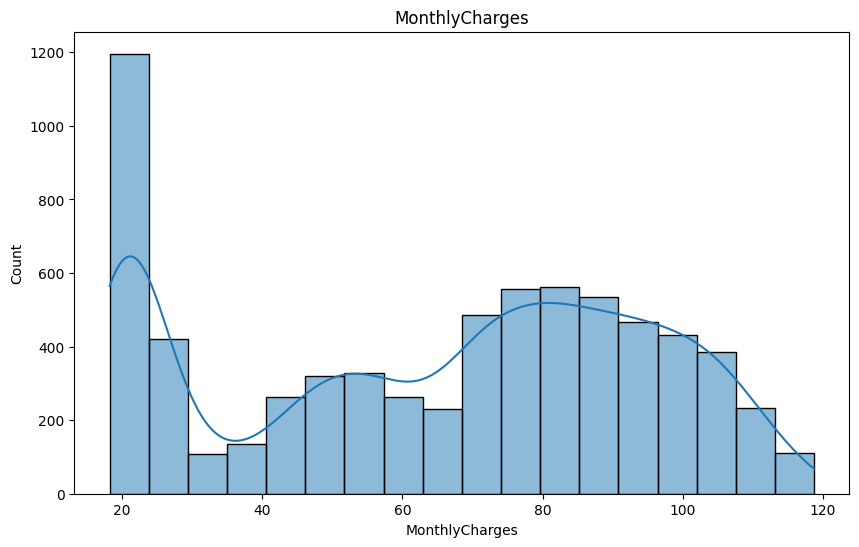

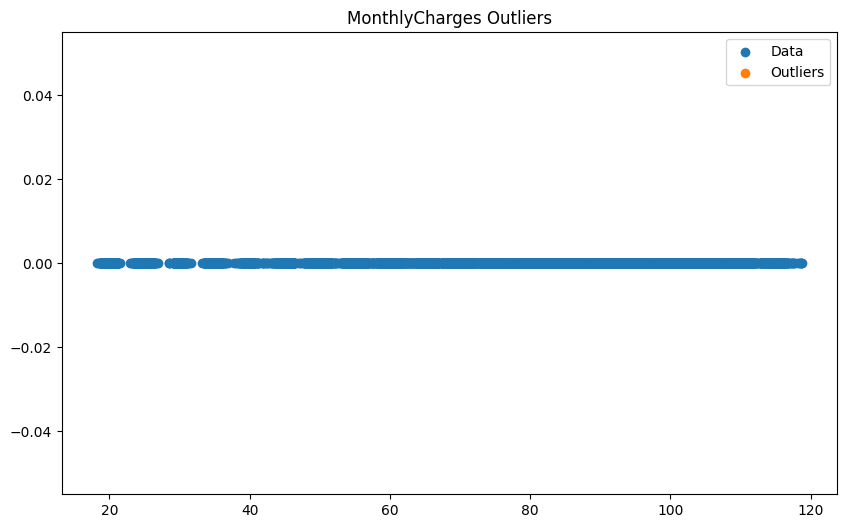

In [ ]:
# Check for outliers in column1
Q1 = df["MonthlyCharges"].quantile(0.25)
Q3 = df["MonthlyCharges"].quantile(0.75)
IQR = Q3 - Q1
outliers = [x for x in df["MonthlyCharges"] if x < Q1 - 1.5 * IQR or x > Q3 + 1.5 * IQR]

# Plot the histogram of column1
plt.figure(figsize=(10, 6))
sns.histplot(data=df["MonthlyCharges"], kde=True)
plt.title("MonthlyCharges")
plt.show()

# Plot the outliers
plt.figure(figsize=(10, 6))
plt.scatter(df["MonthlyCharges"], np.zeros(len(df["MonthlyCharges"])), label="Data")
plt.scatter(outliers, np.zeros(len(outliers)), label="Outliers")
plt.title("MonthlyCharges Outliers")
plt.legend()
plt.show()

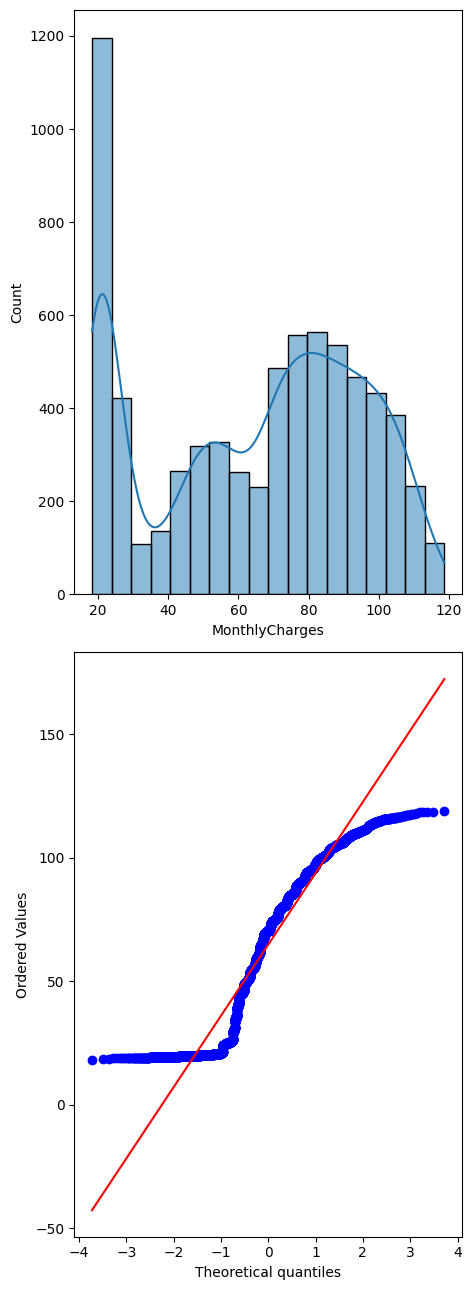

In [ ]:
import scipy.stats as stats
plt.figure(figsize=(17,13))
# for i in list(enumerate(df['MonthlyCharges'])):
plt.subplot(2, 4, 1)
sns.histplot(data = df['MonthlyCharges'], kde=True)  # Histogram with KDE line

# for i in list(enumerate(df.columns)):
plt.subplot(2, 4, 5)
stats.probplot(df['MonthlyCharges'], dist="norm", plot=plt)   # QQ Plot
plt.title("")
plt.tight_layout()
plt.show()

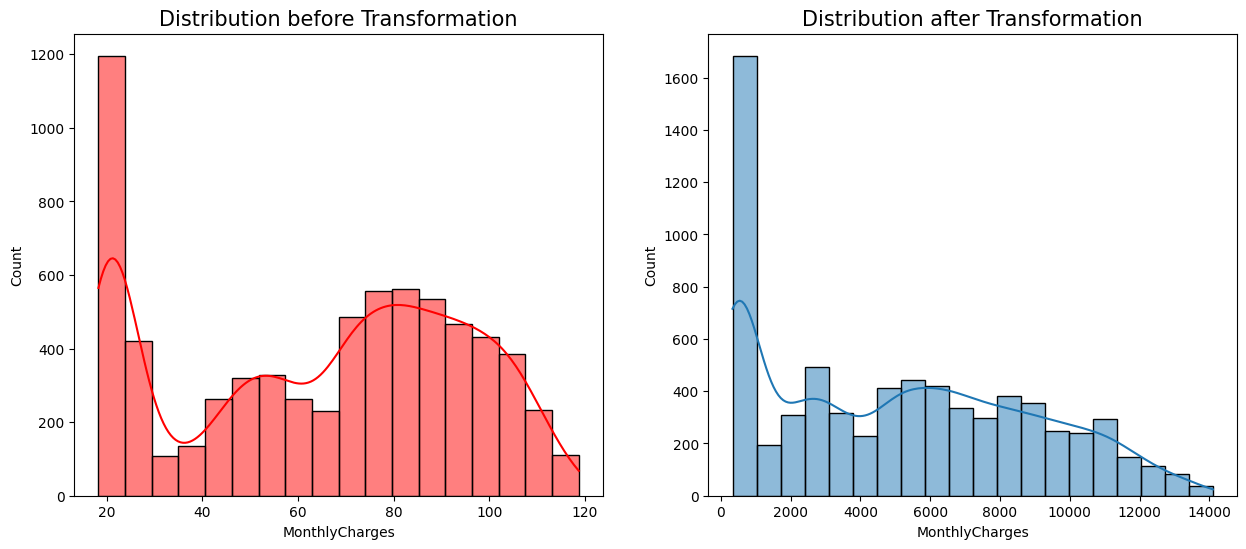

Skewness was -0.22210292770166232 before & is 0    0.299223
dtype: float64 after Square transformation.


In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
old_skew = df['MonthlyCharges'].skew()

def squareTrans(feature):   # function to apply transformer and check the distribution with histogram and kdeplot

    logTr = ColumnTransformer(transformers=[("lg", FunctionTransformer(np.square), [feature])])

    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.title("Distribution before Transformation", fontsize=15)
    sns.histplot(df[feature], kde=True, color="red")
    plt.subplot(1,2,2)

    df_square = pd.DataFrame(logTr.fit_transform(df))
    plt.title("Distribution after Transformation", fontsize=15)
    sns.histplot(df_square,bins=20, kde=True , legend=False)
    plt.xlabel(feature)
    plt.show()

    print(f"Skewness was {old_skew} before & is {df_square.skew()} after Square transformation.")

squareTrans(feature="MonthlyCharges")

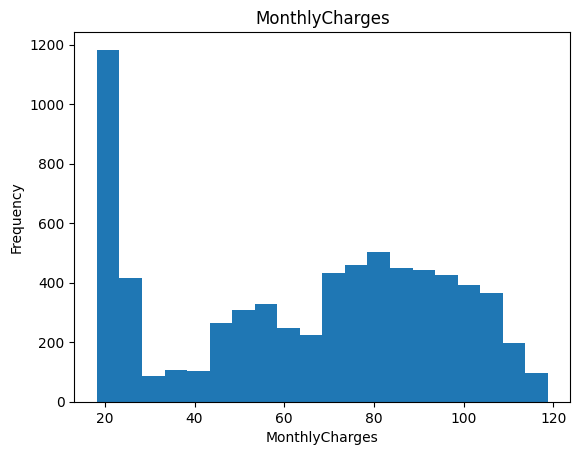

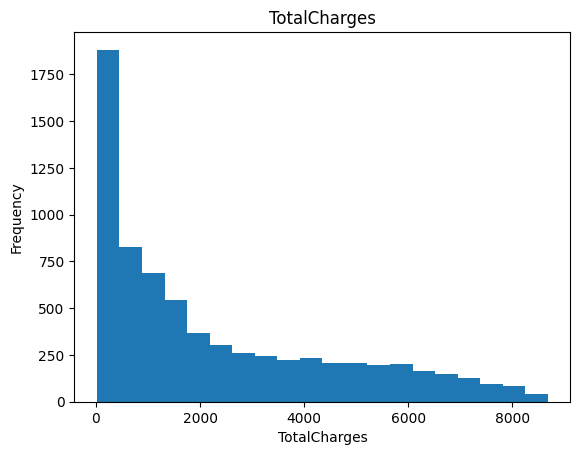

In [ ]:
# Add titles to the axes
MonthlyCharges_hist = plt.hist(df['MonthlyCharges'], bins=20)
plt.title("MonthlyCharges")
plt.xlabel("MonthlyCharges")
plt.ylabel("Frequency")
plt.show()
TotalCharges_hist = plt.hist(df['TotalCharges'], bins=20)
plt.title("TotalCharges")
plt.xlabel("TotalCharges")
plt.ylabel("Frequency")
plt.show()

In [ ]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### **Continuing Same with same data/No normalization & Outlier work as of now**

In [ ]:
df['Churn'].value_counts()

No     5163
Yes    1869
Name: Churn, dtype: Int64

In [ ]:
df_minority_data=df.loc[df['Churn'] == 'Yes']
#Subsetting input features without target variable
df_minority_data_withouttv=df_minority_data.loc[:, df_minority_data.columns != 'Churn']

In [ ]:
numerical_df = df_minority_data_withouttv.select_dtypes("number")
categorical_df = df_minority_data_withouttv.select_dtypes("string")
scaling = MinMaxScaler()
numerical_df_rescaled = scaling.fit_transform(numerical_df)
get_dummy_df = pd.get_dummies(categorical_df)

In [ ]:
numerical_df.head(2)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
2,0,2,53.85,108.15
4,0,2,70.70,151.65


In [ ]:
# Point to be considered and discuss
from scipy.stats import skew
skewness = skew(numerical_df_rescaled)
print(skewness)

[ 1.1261346   1.14835771 -0.72878831  1.50970172]


In [ ]:
categorical_df.head(2)

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
2,3668-QPYBK,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check
4,9237-HQITU,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check


In [ ]:
categorical_df.columns

Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [ ]:
# Seperating Each Category
# Think about CustomerID, should keep or remove
customerID_dummy_col = [col for col in get_dummy_df.columns if 'customerID' in col]
customerID_dummy = get_dummy_df[customerID_dummy_col]
gender_dummy_col = [col for col in get_dummy_df.columns if 'gender' in col]
gender_dummy = get_dummy_df[gender_dummy_col]
Partner_dummy_col = [col for col in get_dummy_df.columns if 'Partner' in col]
Partner_dummy = get_dummy_df[Partner_dummy_col]
Dependents_dummy_col = [col for col in get_dummy_df.columns if 'Dependents' in col]
Dependents_dummy = get_dummy_df[Dependents_dummy_col]
PhoneService_dummy_col = [col for col in get_dummy_df.columns if 'PhoneService' in col]
PhoneService_dummy = get_dummy_df[PhoneService_dummy_col]
MultipleLines_dummy_col = [col for col in get_dummy_df.columns if 'MultipleLines' in col]
MultipleLines_dummy = get_dummy_df[MultipleLines_dummy_col]
InternetService_dummy_col = [col for col in get_dummy_df.columns if 'InternetService' in col]
InternetService_dummy = get_dummy_df[InternetService_dummy_col]
OnlineSecurity_dummy_col = [col for col in get_dummy_df.columns if 'OnlineSecurity' in col]
OnlineSecurity_dummy = get_dummy_df[OnlineSecurity_dummy_col]
OnlineBackup_dummy_col = [col for col in get_dummy_df.columns if 'OnlineBackup' in col]
OnlineBackup_dummy = get_dummy_df[OnlineBackup_dummy_col]
DeviceProtection_dummy_col = [col for col in get_dummy_df.columns if 'DeviceProtection' in col]
DeviceProtection_dummy = get_dummy_df[DeviceProtection_dummy_col]
TechSupport_dummy_col = [col for col in get_dummy_df.columns if 'TechSupport' in col]
TechSupport_dummy = get_dummy_df[TechSupport_dummy_col]
StreamingTV_dummy_col = [col for col in get_dummy_df.columns if 'StreamingTV' in col]
StreamingTV_dummy = get_dummy_df[StreamingTV_dummy_col]
StreamingMovies_dummy_col = [col for col in get_dummy_df.columns if 'StreamingMovies' in col]
StreamingMovies_dummy = get_dummy_df[StreamingMovies_dummy_col]
Contract_dummy_col = [col for col in get_dummy_df.columns if 'Contract' in col]
Contract_dummy = get_dummy_df[Contract_dummy_col]
PaperlessBilling_dummy_col = [col for col in get_dummy_df.columns if 'PaperlessBilling' in col]
PaperlessBilling_dummy = get_dummy_df[PaperlessBilling_dummy_col]
PaymentMethod_dummy_col = [col for col in get_dummy_df.columns if 'PaymentMethod' in col]
PaymentMethod_dummy = get_dummy_df[PaymentMethod_dummy_col]

# **Defining the Generator**

In [ ]:
categorical_df.columns

Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [ ]:
def define_generator (catsh1,catsh2,catsh3,catsh4,catsh5,catsh6,catsh7,catsh8,catsh9,catsh10,catsh11,catsh12,catsh13,catsh14,catsh15,catsh16,numerical):
  #Inputting noise  from latent space
    noise = Input(shape = (100,))
    hidden_1 = Dense(8, kernel_initializer = "he_uniform")(noise)
    hidden_1 = LeakyReLU(0.2)(hidden_1)
    hidden_1 = BatchNormalization(momentum = 0.8)(hidden_1)
    hidden_2 = Dense(16, kernel_initializer = "he_uniform")(hidden_1)
    hidden_2 = LeakyReLU(0.2)(hidden_2)
    hidden_2 = BatchNormalization(momentum = 0.8)(hidden_2)

    #Branch 1 for generating customerID data

    branch_1 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_1 = LeakyReLU(0.2)(branch_1)
    branch_1 = BatchNormalization(momentum = 0.8)(branch_1)
    branch_1 = Dense(64, kernel_initializer = "he_uniform")(branch_1)
    branch_1 = LeakyReLU(0.2)(branch_1)
    branch_1 = BatchNormalization(momentum=0.8)(branch_1)
    #Output Layer1
    branch_1_output = Dense(catsh1, activation = "softmax")(branch_1)

    #Branch 2 for generating gender data

    branch_2 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_2 = LeakyReLU(0.2)(branch_2)
    branch_2 = BatchNormalization(momentum = 0.8)(branch_2)
    branch_2 = Dense(64, kernel_initializer = "he_uniform")(branch_2)
    branch_2 = LeakyReLU(0.2)(branch_2)
    branch_2 = BatchNormalization(momentum=0.8)(branch_2)
    #Output Layer2
    branch_2_output = Dense(catsh2, activation = "softmax")(branch_2)

    #Branch 3 for generating SeniorCitizen data

    branch_3 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_3 = LeakyReLU(0.2)(branch_3)
    branch_3 = BatchNormalization(momentum = 0.8)(branch_3)
    branch_3 = Dense(64, kernel_initializer = "he_uniform")(branch_3)
    branch_3 = LeakyReLU(0.2)(branch_3)
    branch_3 = BatchNormalization(momentum=0.8)(branch_3)
    #Output Layer3
    branch_3_output = Dense(catsh3, activation = "softmax")(branch_3)

    #Branch 4 for generating Partner data

    branch_4 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_4 = LeakyReLU(0.2)(branch_4)
    branch_4 = BatchNormalization(momentum = 0.8)(branch_4)
    branch_4 = Dense(64, kernel_initializer = "he_uniform")(branch_4)
    branch_4 = LeakyReLU(0.2)(branch_4)
    branch_4 = BatchNormalization(momentum=0.8)(branch_4)
    #Output Layer4
    branch_4_output = Dense(catsh4, activation = "softmax")(branch_4)

    #Branch 5 for generating Dependents data

    branch_5 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_5 = LeakyReLU(0.2)(branch_5)
    branch_5 = BatchNormalization(momentum = 0.8)(branch_5)
    branch_5 = Dense(64, kernel_initializer = "he_uniform")(branch_5)
    branch_5 = LeakyReLU(0.2)(branch_5)
    branch_5 = BatchNormalization(momentum=0.8)(branch_5)
    #Output Layer5
    branch_5_output = Dense(catsh5, activation = "softmax")(branch_5)

    #Branch 6 for generating PhoneService data

    branch_6 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_6 = LeakyReLU(0.2)(branch_6)
    branch_6 = BatchNormalization(momentum = 0.8)(branch_6)
    branch_6 = Dense(64, kernel_initializer = "he_uniform")(branch_6)
    branch_6 = LeakyReLU(0.2)(branch_6)
    branch_6 = BatchNormalization(momentum=0.8)(branch_6)
    #Output Layer6
    branch_6_output = Dense(catsh6, activation = "softmax")(branch_6)

    #Branch 7 for generating MultipleLines data

    branch_7 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_7 = LeakyReLU(0.2)(branch_7)
    branch_7 = BatchNormalization(momentum = 0.8)(branch_7)
    branch_7 = Dense(64, kernel_initializer = "he_uniform")(branch_7)
    branch_7 = LeakyReLU(0.2)(branch_7)
    branch_7 = BatchNormalization(momentum=0.8)(branch_7)
    #Output Layer7
    branch_7_output = Dense(catsh7, activation = "softmax")(branch_7)

    #Branch 8 for generating InternetService data

    branch_8 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_8 = LeakyReLU(0.2)(branch_8)
    branch_8 = BatchNormalization(momentum = 0.8)(branch_8)
    branch_8 = Dense(64, kernel_initializer = "he_uniform")(branch_8)
    branch_8 = LeakyReLU(0.2)(branch_8)
    branch_8 = BatchNormalization(momentum=0.8)(branch_8)
    #Output Layer8
    branch_8_output = Dense(catsh8, activation = "softmax")(branch_8)

    #Branch 9 for generating OnlineSecurity data

    branch_9 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_9 = LeakyReLU(0.2)(branch_9)
    branch_9 = BatchNormalization(momentum = 0.8)(branch_9)
    branch_9 = Dense(64, kernel_initializer = "he_uniform")(branch_9)
    branch_9 = LeakyReLU(0.2)(branch_9)
    branch_9 = BatchNormalization(momentum=0.8)(branch_9)
    #Output Layer9
    branch_9_output = Dense(catsh9, activation = "softmax")(branch_9)

    #Branch 10 for generating OnlineBackup data

    branch_10 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_10 = LeakyReLU(0.2)(branch_10)
    branch_10 = BatchNormalization(momentum = 0.8)(branch_10)
    branch_10 = Dense(64, kernel_initializer = "he_uniform")(branch_10)
    branch_10 = LeakyReLU(0.2)(branch_10)
    branch_10 = BatchNormalization(momentum=0.8)(branch_10)
    #Output Layer10
    branch_10_output = Dense(catsh10, activation = "softmax")(branch_10)

    #Branch 11 for generating DeviceProtection data

    branch_11 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_11 = LeakyReLU(0.2)(branch_11)
    branch_11 = BatchNormalization(momentum = 0.8)(branch_11)
    branch_11 = Dense(64, kernel_initializer = "he_uniform")(branch_11)
    branch_11 = LeakyReLU(0.2)(branch_11)
    branch_11 = BatchNormalization(momentum=0.8)(branch_11)
    #Output Layer11
    branch_11_output = Dense(catsh11, activation = "softmax")(branch_11)

    #Branch 12 for generating StreamingTV data

    branch_12 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_12 = LeakyReLU(0.2)(branch_12)
    branch_12 = BatchNormalization(momentum = 0.8)(branch_12)
    branch_12 = Dense(64, kernel_initializer = "he_uniform")(branch_12)
    branch_12 = LeakyReLU(0.2)(branch_12)
    branch_12 = BatchNormalization(momentum=0.8)(branch_12)
    #Output Layer12
    branch_12_output = Dense(catsh12, activation = "softmax")(branch_12)

    #Branch 13 for generating StreamingMovies data

    branch_13 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_13 = LeakyReLU(0.2)(branch_13)
    branch_13 = BatchNormalization(momentum = 0.8)(branch_13)
    branch_13 = Dense(64, kernel_initializer = "he_uniform")(branch_13)
    branch_13 = LeakyReLU(0.2)(branch_13)
    branch_13 = BatchNormalization(momentum=0.8)(branch_13)
    #Output Layer13
    branch_13_output = Dense(catsh13, activation = "softmax")(branch_13)

    #Branch 14 for generating Contract data

    branch_14 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_14 = LeakyReLU(0.2)(branch_14)
    branch_14 = BatchNormalization(momentum = 0.8)(branch_14)
    branch_14 = Dense(64, kernel_initializer = "he_uniform")(branch_14)
    branch_14 = LeakyReLU(0.2)(branch_14)
    branch_14 = BatchNormalization(momentum=0.8)(branch_14)
    #Output Layer14
    branch_14_output = Dense(catsh14, activation = "softmax")(branch_14)

    #Branch 15 for generating PaperlessBilling data

    branch_15 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_15 = LeakyReLU(0.2)(branch_15)
    branch_15 = BatchNormalization(momentum = 0.8)(branch_15)
    branch_15 = Dense(64, kernel_initializer = "he_uniform")(branch_15)
    branch_15 = LeakyReLU(0.2)(branch_15)
    branch_15 = BatchNormalization(momentum=0.8)(branch_15)
    #Output Layer15
    branch_15_output = Dense(catsh15, activation = "softmax")(branch_15)

    #Branch 16 for generating PaymentMethod data

    branch_16 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_16 = LeakyReLU(0.2)(branch_16)
    branch_16 = BatchNormalization(momentum = 0.8)(branch_16)
    branch_16 = Dense(64, kernel_initializer = "he_uniform")(branch_16)
    branch_16 = LeakyReLU(0.2)(branch_16)
    branch_16 = BatchNormalization(momentum=0.8)(branch_16)
    #Output Layer16
    branch_16_output = Dense(catsh16, activation = "softmax")(branch_16)

    #Branch 17 for generating numerical data
    branch_17 = Dense(64, kernel_initializer = "he_uniform")(hidden_2)
    branch_17 = LeakyReLU(0.2)(branch_17)
    branch_17 = BatchNormalization(momentum=0.8)(branch_17)
    branch_17 = Dense(128, kernel_initializer = "he_uniform")(branch_17)
    branch_17 = LeakyReLU(0.2)(branch_17)
    branch_17 = BatchNormalization(momentum=0.8)(branch_17)
    #Output Layer17
    branch_17_output = Dense(numerical, activation = "sigmoid")(branch_17)

    #Combined output
    combined_output = concatenate([branch_1_output, branch_2_output, branch_3_output,branch_4_output,branch_5_output,branch_6_output,branch_7_output,branch_8_output,branch_9_output,branch_10_output,branch_11_output,branch_12_output,branch_13_output,branch_14_output,branch_15_output,branch_16_output,branch_17_output])

    #compile and return model
    model = Model(inputs = noise, outputs = combined_output)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0002, beta_1=0.5), metrics = ["accuracy"])

    return model

generator = define_generator(customerID_dummy.shape[1], gender_dummy.shape[1], Partner_dummy.shape[1], Dependents_dummy.shape[1], PhoneService_dummy.shape[1],MultipleLines_dummy.shape[1], InternetService_dummy.shape[1], OnlineSecurity_dummy.shape[1],
OnlineBackup_dummy.shape[1],DeviceProtection_dummy.shape[1], TechSupport_dummy.shape[1], StreamingTV_dummy.shape[1], StreamingMovies_dummy.shape[1],Contract_dummy.shape[1], PaperlessBilling_dummy.shape[1], PaymentMethod_dummy.shape[1],
numerical_df_rescaled.shape[1])

generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 8)            808         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 8)            0           ['dense[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 8)           32          ['leaky_re_lu[0][0]']            
 alization)                                                                                   

# **Defining the Discriminator**

In [ ]:
def define_discriminator(inputs_dn):
    #Input from generator
    d_input = Input(shape = (inputs_dn,))
    d = Dense(128, kernel_initializer="he_uniform")(d_input)
    d = LeakyReLU(0.2)(d)
    d = Dense(64, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(32, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(16, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(8, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)

    #Output Layer
    d_output = Dense(1, activation = "sigmoid")(d)

    #compile and return model
    model = Model(inputs = d_input, outputs = d_output)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0002, beta_1=0.5), metrics = ["accuracy"])
    return model


inputs_dn = customerID_dummy.shape[1]+ gender_dummy.shape[1]+ Partner_dummy.shape[1]+ Dependents_dummy.shape[1]+ PhoneService_dummy.shape[1]+MultipleLines_dummy.shape[1]+ InternetService_dummy.shape[1]+ OnlineSecurity_dummy.shape[1]+OnlineBackup_dummy.shape[1]+DeviceProtection_dummy.shape[1]+ TechSupport_dummy.shape[1]+ StreamingTV_dummy.shape[1]+ StreamingMovies_dummy.shape[1]+Contract_dummy.shape[1]+ PaperlessBilling_dummy.shape[1]+ PaymentMethod_dummy.shape[1]+numerical_df_rescaled.shape[1]

discriminator = define_discriminator(inputs_dn)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1914)]            0         
                                                                 
 dense_53 (Dense)            (None, 128)               245120    
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 128)               0         
                                                                 
 dense_54 (Dense)            (None, 64)                8256      
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_55 (Dense)            (None, 32)                2080      
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 32)                0   

In [ ]:
def define_complete_gan(generator, discriminator):
    discriminator.trainable = False
    gan_output = discriminator(generator.output)

    #Initialize gan
    model = Model(inputs = generator.input, outputs = gan_output)

    #Model Compilation
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0002, beta_1=0.5))
    return model

completegan = define_complete_gan(generator, discriminator)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 31ms/step
[[3.6515571e-10 8.8464192e-10 5.7179023e-10 ... 2.0569083e-04
  8.1852621e-01 1.3911047e-04]
 [3.9500600e-10 2.4188247e-12 2.6568925e-09 ... 5.0377958e-03
  6.6599375e-01 2.9456797e-03]
 [1.5762119e-07 2.3531401e-11 1.3712238e-08 ... 8.2770287e-04
  3.9904979e-01 1.4510135e-03]
 ...
 [1.0576231e-08 1.9167898e-11 2.3721450e-10 ... 2.6307618e-05
  2.0192958e-02 3.0131587e-05]
 [2.4505777e-12 2.7013472e-13 1.5770640e-14 ... 2.1510184e-01
  9.1835225e-01 2.0178170e-03]
 [1.6155133e-15 2.1605706e-12 2.7918935e-12 ... 3.1420239e-04
  2.4211825e-08 1.3225660e-06]]
1/1 [==============================] - 0s 29ms/step
[[1.8920519e-13 8.4737366e-13 3.3330938e-08 ... 2.4176715e-02
  9.8948795e-01 1.1305597e-03]
 [7.2735281e-07 5.6693577e-11 4.3371702e-09 ... 9.4715442e-06
  3.3120075e-01 4.0475363e-05]
 [4.4648644e-13 1.0493778e-12 5.9022760e-08 ... 9.6257947e-02
  8.5392511e-01 2.5382303e-03]
 .

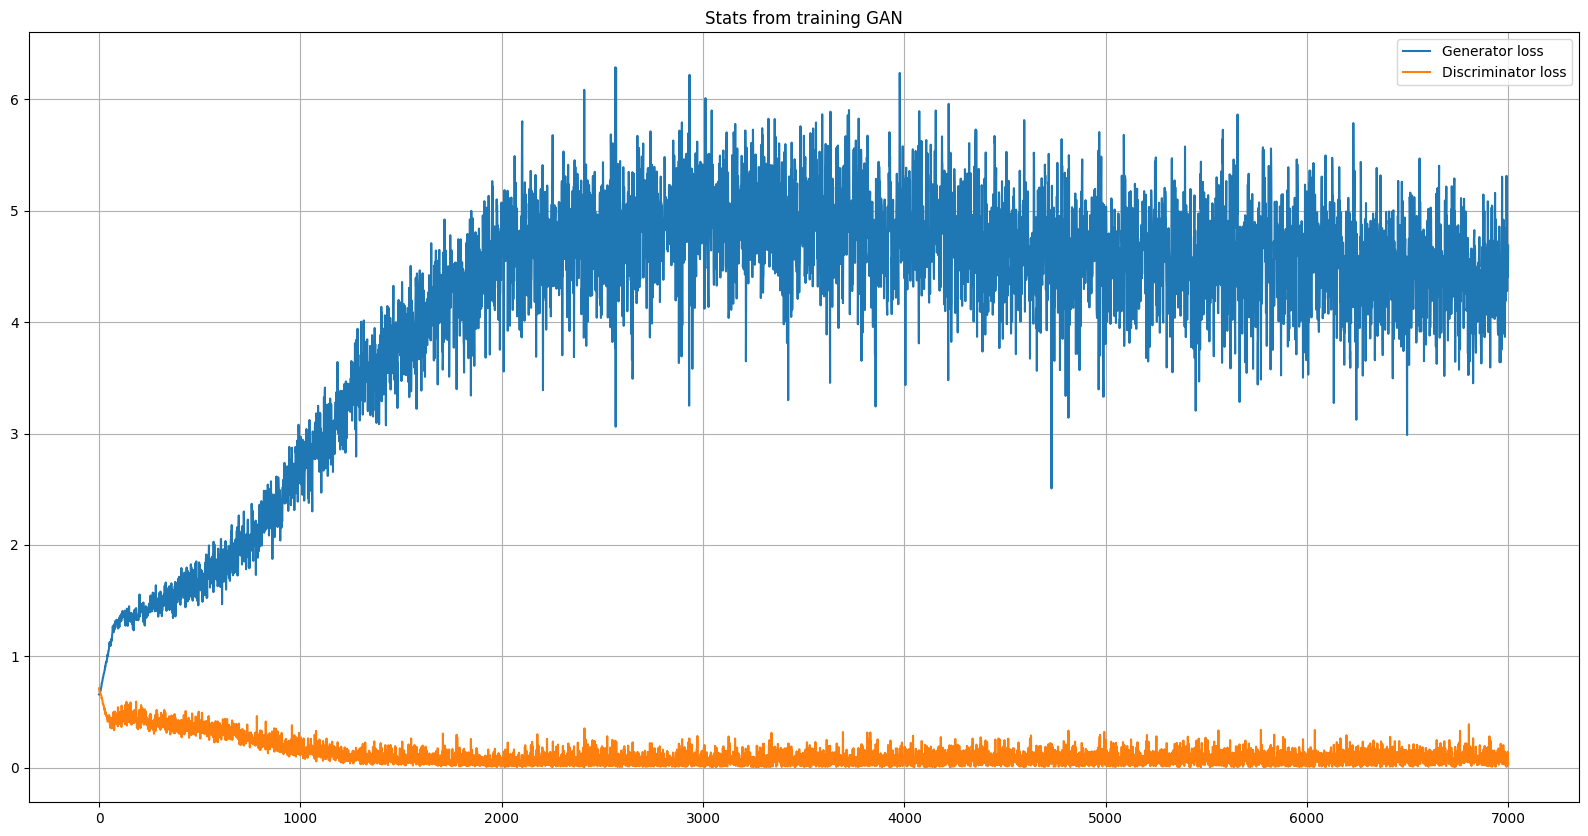

In [ ]:
def gan_train(gan, generator, discriminator, catsh1,catsh2,catsh3,catsh4,catsh5,catsh6,catsh7,catsh8,catsh9,catsh10,catsh11,catsh12,catsh13,catsh14,catsh15,catsh16,numerical, latent_dim, n_epochs, n_batch, n_eval):
    #Update Discriminator with half batch size
    half_batch = int(n_batch / 2)
    discriminator_loss = []
    generator_loss = []
    #generate class labels for fake and real
    valid = np.ones((half_batch, 1))
    y_gan = np.ones((n_batch, 1))
    fake = np.zeros((half_batch, 1))

    #training
    for i in range(n_epochs):
        #select random batch from real categorical and numerical data
        idx = np.random.randint(0, catsh1.shape[0], half_batch)
        customerID_real = catsh1[idx]
        gender_real = catsh2[idx]
        Partner_real = catsh3[idx]
        Dependents_real = catsh4[idx]
        PhoneService_real = catsh5[idx]
        MultipleLines_real = catsh6[idx]
        InternetService_real = catsh7[idx]
        OnlineSecurity_real = catsh8[idx]
        OnlineBackup_real = catsh9[idx]
        DeviceProtection_real = catsh10[idx]
        TechSupport_real = catsh11[idx]
        StreamingTV_real = catsh12[idx]
        StreamingMovies_real = catsh13[idx]
        Contract_real = catsh14[idx]
        PaperlessBilling_real = catsh15[idx]
        PaymentMethod_real = catsh16[idx]
        numerical_real = numerical_df_rescaled[idx]

        #concatenate categorical and numerical data for the discriminator
        real_data = np.concatenate([customerID_real, gender_real, Partner_real, Dependents_real, PhoneService_real, MultipleLines_real, InternetService_real,
                                    OnlineSecurity_real, OnlineBackup_real, DeviceProtection_real, TechSupport_real, StreamingTV_real, StreamingMovies_real,
                                    Contract_real, PaperlessBilling_real, PaymentMethod_real, numerical_real], axis = 1)

        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise)
        print(fake_data)
        #train the discriminator and return losses and acc
        d_loss_real, da_real = discriminator.train_on_batch(real_data, valid)
        d_loss_fake, da_fake = discriminator.train_on_batch(fake_data, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator_loss.append(d_loss)

        #generate noise for generator input and train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, latent_dim))
        g_loss = gan.train_on_batch(noise, y_gan)
        generator_loss.append(g_loss)

        #evaluate progress
        if (i+1) % n_eval == 0:
            print ("Epoch: %d [Discriminator loss: %f] [Generator loss: %f]" % (i + 1, d_loss, g_loss))

    plt.figure(figsize = (20, 10))
    plt.plot(generator_loss, label = "Generator loss")
    plt.plot(discriminator_loss, label = "Discriminator loss")
    plt.title("Stats from training GAN")
    plt.grid()
    plt.legend()

latent_dim = 100
gan_train(completegan, generator, discriminator, customerID_dummy.values, gender_dummy.values, Partner_dummy.values, Dependents_dummy.values, PhoneService_dummy.values,MultipleLines_dummy.values, InternetService_dummy.values, OnlineSecurity_dummy.values,OnlineBackup_dummy.values,DeviceProtection_dummy.values, TechSupport_dummy.values, StreamingTV_dummy.values, StreamingMovies_dummy.values,Contract_dummy.values, PaperlessBilling_dummy.values, PaymentMethod_dummy.values,numerical_df_rescaled, latent_dim, n_epochs = 7000, n_batch = 63, n_eval = 200)

In [ ]:
noise = np.random.normal(0, 1, (96, 100))
generated_mixed_data = generator.predict(noise)
columns= list(customerID_dummy.columns)+list(gender_dummy.columns)+list(Partner_dummy.columns)+list(Dependents_dummy.columns)+list(PhoneService_dummy.columns)+list(MultipleLines_dummy.columns)+list(InternetService_dummy.columns)+list(OnlineSecurity_dummy.columns)+list(OnlineBackup_dummy.columns)+list(DeviceProtection_dummy.columns)+list(TechSupport_dummy.columns)+list(StreamingTV_dummy.columns)+list(StreamingMovies_dummy.columns)+list(Contract_dummy.columns)+list(PaperlessBilling_dummy.columns)+list(PaymentMethod_dummy.columns)+list(numerical_df.columns)
mixed_gen_df = pd.DataFrame(data = generated_mixed_data, columns = columns)
mixed_gen_df.iloc[:,:-4] = np.round(mixed_gen_df.iloc[:,:-4])
mixed_gen_df.iloc[:,-4:] = scaling.inverse_transform(mixed_gen_df.iloc[:,-4:])

3/3 [==============================] - 0s 7ms/step


SeniorCitizen Comparison between Original Data and Generated Data


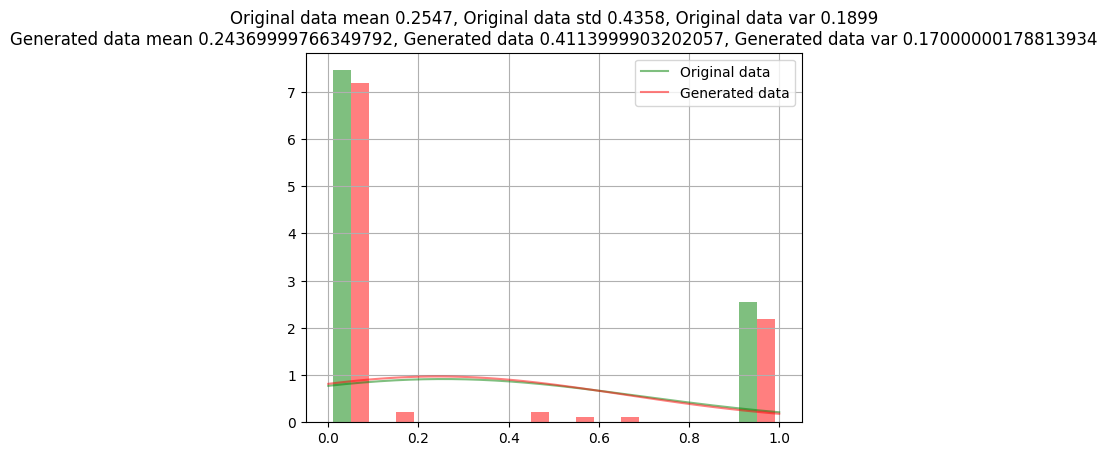

tenure Comparison between Original Data and Generated Data


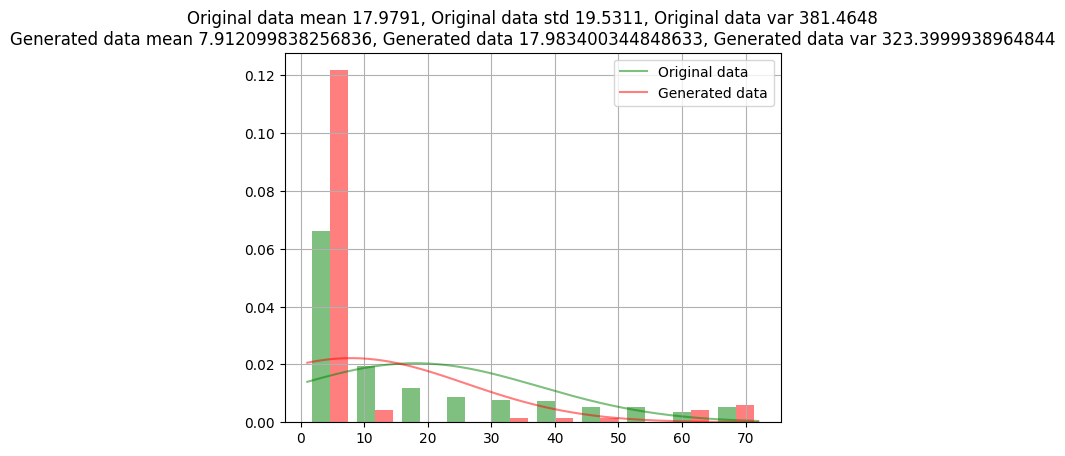

MonthlyCharges Comparison between Original Data and Generated Data


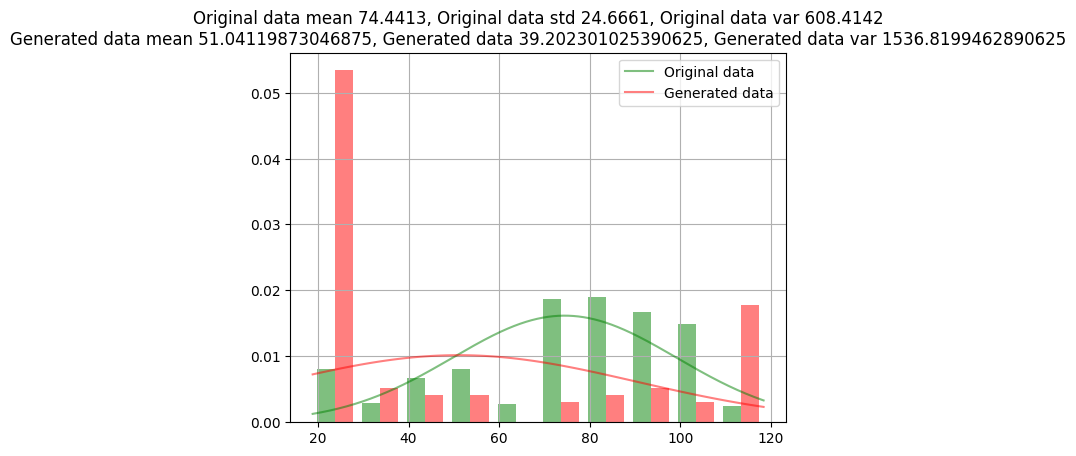

TotalCharges Comparison between Original Data and Generated Data


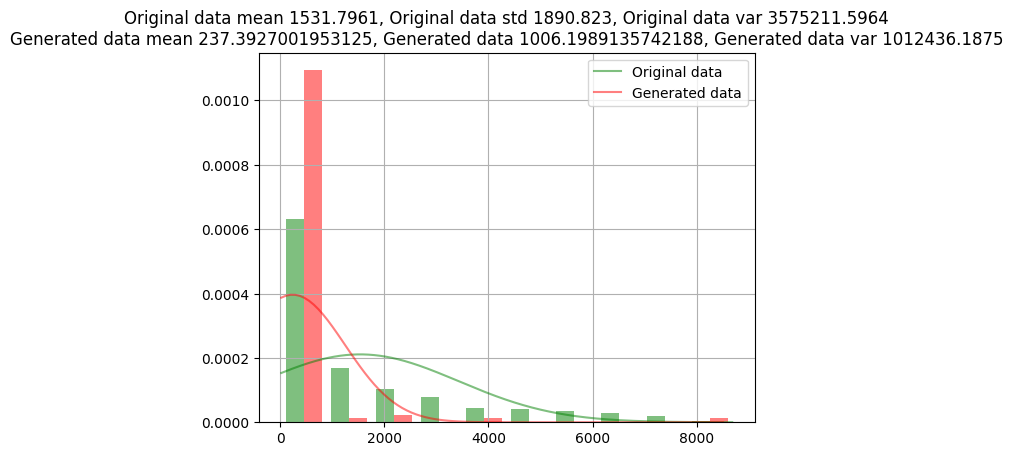

In [ ]:
# Original Data
original_df = pd.concat([customerID_dummy, gender_dummy, Partner_dummy, Dependents_dummy, PhoneService_dummy,MultipleLines_dummy, InternetService_dummy, OnlineSecurity_dummy,OnlineBackup_dummy,DeviceProtection_dummy, TechSupport_dummy, StreamingTV_dummy, StreamingMovies_dummy,Contract_dummy, PaperlessBilling_dummy, PaymentMethod_dummy,numerical_df], axis = 1)
def normal_distribution(org, noise):
    org_x = np.linspace(org.min(), org.max(), len(org))
    noise_x = np.linspace(noise.min(), noise.max(), len(noise))
    org_y = scipy.stats.norm.pdf(org_x, org.mean(), org.std())
    noise_y = scipy.stats.norm.pdf(noise_x, noise.mean(), noise.std())
    n, bins, patches = plt.hist([org, noise], density = True, alpha = 0.5, color = ["green", "red"])
    xmin, xmax = plt.xlim()
    plt.plot(org_x, org_y, color = "green", label = "Original data", alpha = 0.5)
    plt.plot(noise_x, noise_y, color = "red", label = "Generated data", alpha = 0.5)
    title = f"Original data mean {np.round(org.mean(), 4)}, Original data std {np.round(org.std(), 4)}, Original data var {np.round(org.var(), 4)}\nGenerated data mean {np.round(noise.mean(), 4)}, Generated data {np.round(noise.std(), 4)}, Generated data var {np.round(noise.var(), 2)}"
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

Numeric_columns=numerical_df.columns

for column in numerical_df.columns:
    print(column, "Comparison between Original Data and Generated Data")
    normal_distribution(original_df[column], mixed_gen_df[column])

In [ ]:
mixed_gen_df.head()

,customerID_0004-TLHLJ,customerID_0011-IGKFF,customerID_0013-EXCHZ,customerID_0022-TCJCI,customerID_0023-HGHWL,customerID_0023-XUOPT,customerID_0031-PVLZI,customerID_0032-PGELS,customerID_0067-DKWBL,customerID_0093-XWZFY,...,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.000000e+00,3.087695,114.412270,1287.698242
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,7.667137e-02,11.838153,32.109680,46.592484
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,9.591440e-01,1.045876,24.883970,20.898472
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.547292e-08,1.085200,70.887459,21.551016
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.409407e-09,2.108399,110.526703,68.039261
